In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

Segmentation Models: using `tf.keras` framework.


In [3]:
#from keras.utils import normalize
from keras.utils.np_utils import normalize
from keras.metrics import MeanIoU

In [4]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
#n_classes=5

In [5]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("indoor_data/Images_128"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        img = cv2.imread(img_path, 1)       
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [6]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("indoor_data/Masks_128"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        mask = cv2.imread(mask_path, 0)       
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [7]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [8]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [9]:
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, shuffle=True, random_state = 42)

#Further split training data to a smaller subset for quick training
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, shuffle=True, random_state = 42)

print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2 3 4 5 6 7 8 9]


In [10]:
from keras.utils.np_utils import to_categorical

n_classes=10

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [11]:
#Reused parameters in all models

n_classes=10
activation='softmax'

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

#dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
#focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

#Total_loss can be imported directly from library
total_loss = sm.losses.binary_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


In [12]:
#VGG-16
BACKBONE3 = 'vgg16'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

In [13]:
#Preprocess input
X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)

In [14]:
#Define model
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)

In [15]:
#Compile keras model with defined optimozer, loss and metrics
model3.compile(optim, total_loss, metrics=metrics)

In [16]:
print(model3.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                           

In [16]:
history3=model3.fit(X_train3, 
          y_train_cat,
          #batch_size=8,
          #batch_size=16,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(X_test3, y_test_cat))

Epoch 1/50
22/22 [==============================] - 192s 8s/step - loss: 0.9845 - iou_score: 0.0025 - f1-score: 0.0049 - val_loss: 0.9479 - val_iou_score: 0.0624 - val_f1-score: 0.0872
Epoch 2/50
22/22 [==============================] - 183s 8s/step - loss: 0.9291 - iou_score: 0.0358 - f1-score: 0.0579 - val_loss: 0.9263 - val_iou_score: 0.0882 - val_f1-score: 0.1233
Epoch 3/50
22/22 [==============================] - 182s 8s/step - loss: 0.8857 - iou_score: 0.1087 - f1-score: 0.1524 - val_loss: 0.8942 - val_iou_score: 0.1235 - val_f1-score: 0.1640
Epoch 4/50
22/22 [==============================] - 182s 8s/step - loss: 0.8551 - iou_score: 0.1400 - f1-score: 0.1859 - val_loss: 0.8715 - val_iou_score: 0.1302 - val_f1-score: 0.1627
Epoch 5/50
22/22 [==============================] - 182s 8s/step - loss: 0.8322 - iou_score: 0.1717 - f1-score: 0.2230 - val_loss: 0.8528 - val_iou_score: 0.1399 - val_f1-score: 0.1831
Epoch 6/50
22/22 [==============================] - 180s 8s/step - loss: 0.

22/22 [==============================] - 182s 8s/step - loss: 0.4311 - iou_score: 0.5262 - f1-score: 0.6029 - val_loss: 0.4913 - val_iou_score: 0.4810 - val_f1-score: 0.5692
Epoch 46/50
22/22 [==============================] - 180s 8s/step - loss: 0.4264 - iou_score: 0.5319 - f1-score: 0.6083 - val_loss: 0.4852 - val_iou_score: 0.4847 - val_f1-score: 0.5763
Epoch 47/50
22/22 [==============================] - 180s 8s/step - loss: 0.4162 - iou_score: 0.5403 - f1-score: 0.6189 - val_loss: 0.4896 - val_iou_score: 0.4836 - val_f1-score: 0.5749
Epoch 48/50
22/22 [==============================] - 180s 8s/step - loss: 0.4154 - iou_score: 0.5407 - f1-score: 0.6204 - val_loss: 0.4869 - val_iou_score: 0.4837 - val_f1-score: 0.5775
Epoch 49/50
22/22 [==============================] - 181s 8s/step - loss: 0.4078 - iou_score: 0.5460 - f1-score: 0.6265 - val_loss: 0.4809 - val_iou_score: 0.4909 - val_f1-score: 0.5831
Epoch 50/50
22/22 [==============================] - 180s 8s/step - loss: 0.4089 -

In [17]:
model3.save('vgg16_backbone_50epochs_32_indoor_f5.hdf5')

# Batch 8 - plots

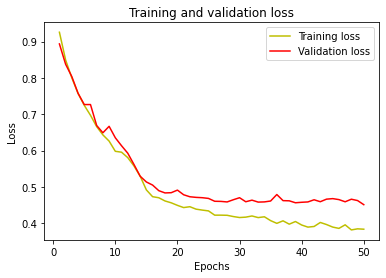

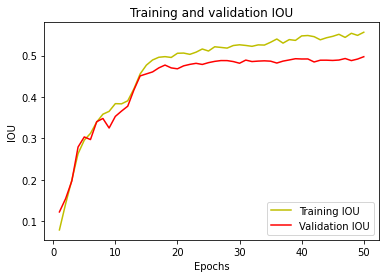

In [18]:
#Fold-1
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

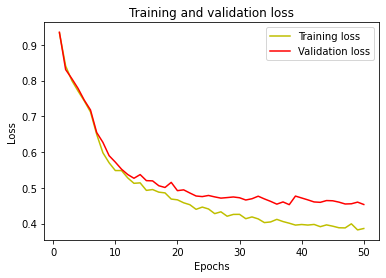

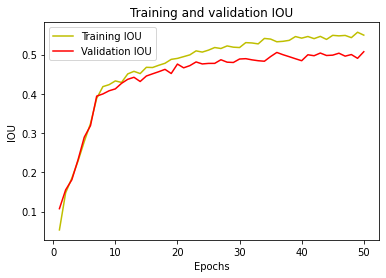

In [18]:
#Fold-2
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

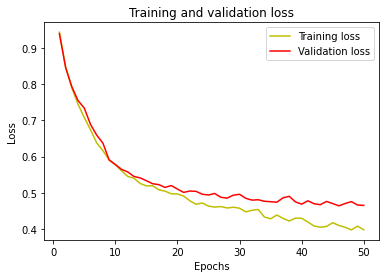

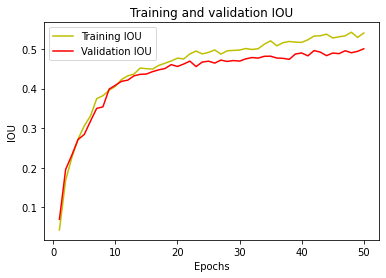

In [18]:
#Fold-3
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

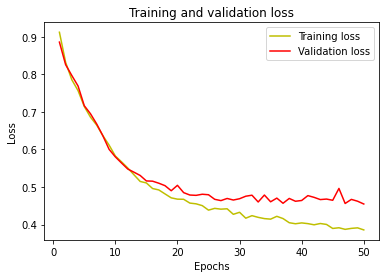

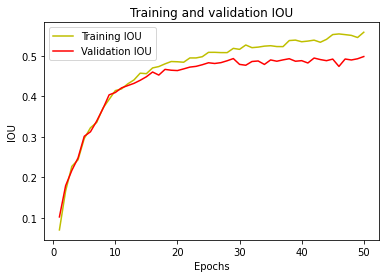

In [18]:
#Fold-4
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

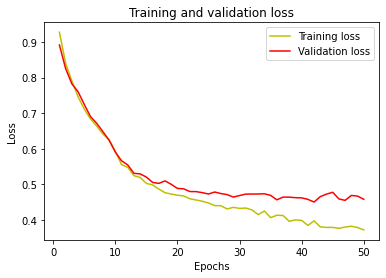

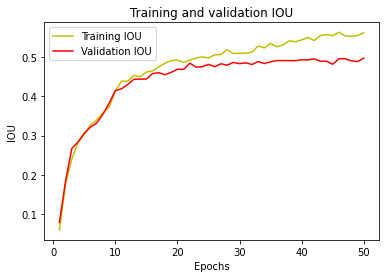

In [18]:
#Fold-5
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

# Batch 16 - plots

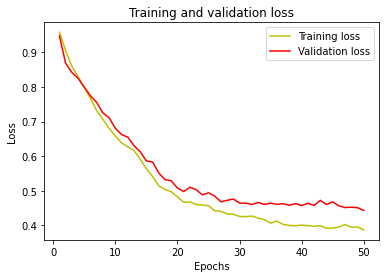

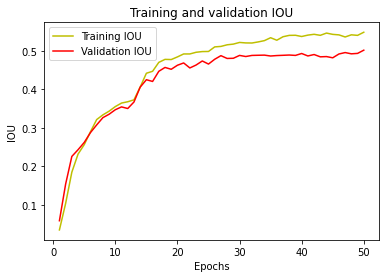

In [18]:
#Fold-1
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

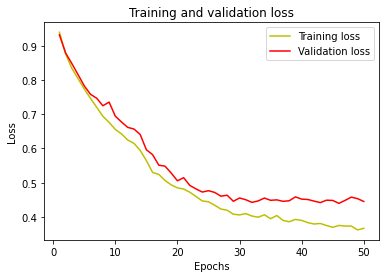

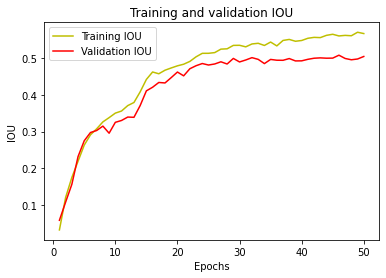

In [18]:
#Fold-2
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

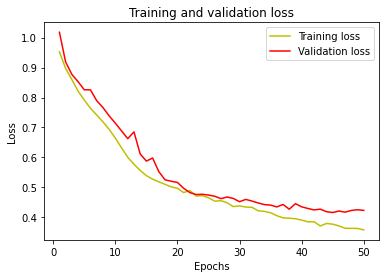

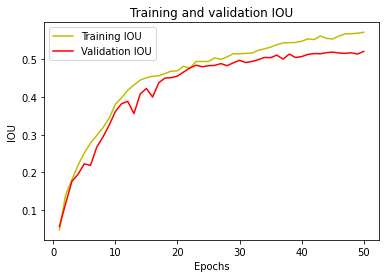

In [18]:
#Fold-3
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

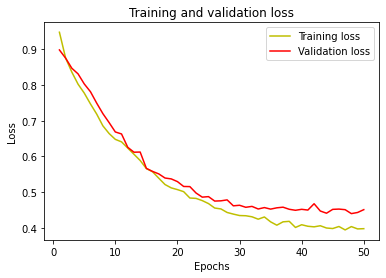

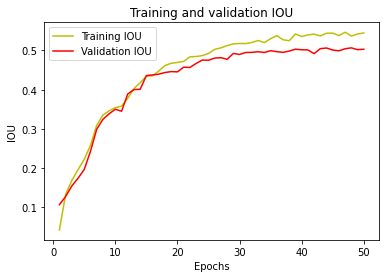

In [18]:
#Fold-4
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

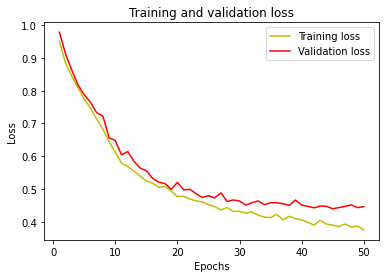

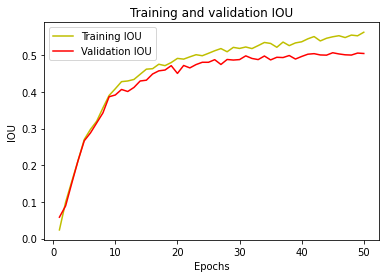

In [19]:
#Fold-5
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

# Batch 32 - plots

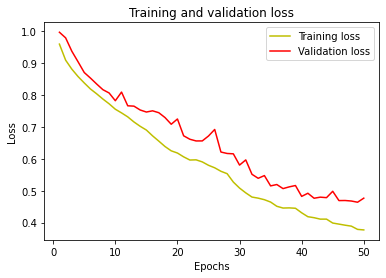

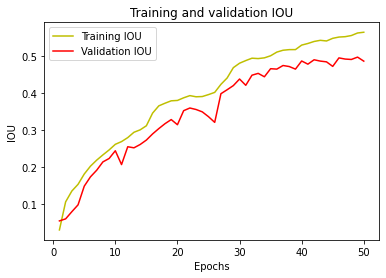

In [18]:
#Fold-1
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

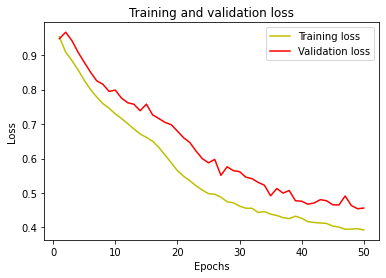

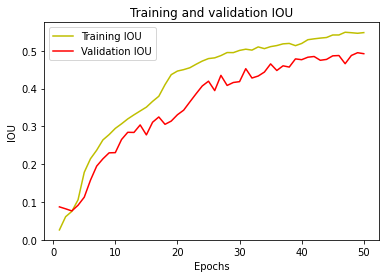

In [18]:
#Fold-2
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

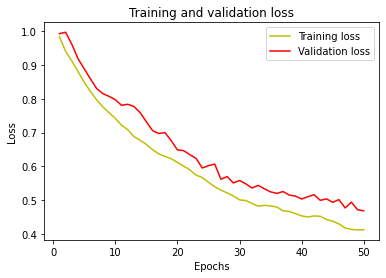

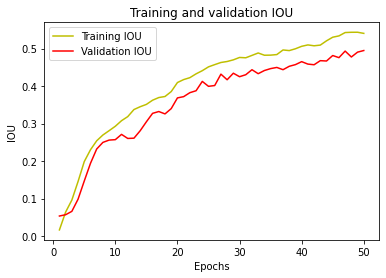

In [18]:
#Fold-3
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

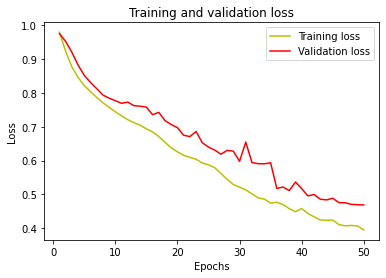

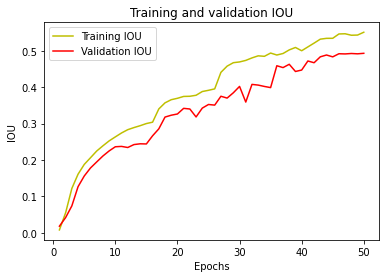

In [18]:
#Fold-4
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

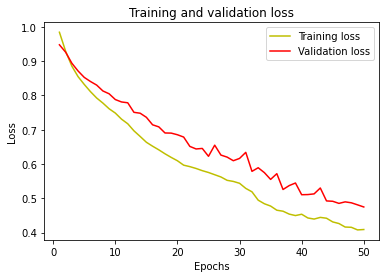

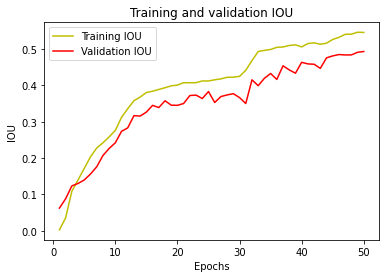

In [18]:
#Fold-5
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [16]:
from keras.models import load_model

#Set compile=False as we are not loading it for training, only for prediction.
#BATCH 8
model3 = load_model('vgg16_backbone_50epochs_indoor_f1.hdf5', compile=False)
#model3 = load_model('vgg16_backbone_50epochs_indoor_f2.hdf5', compile=False)
#model3 = load_model('vgg16_backbone_50epochs_indoor_f3.hdf5', compile=False)
#model3 = load_model('vgg16_backbone_50epochs_indoor_f4.hdf5', compile=False)
#model3 = load_model('vgg16_backbone_50epochs_indoor_f5.hdf5', compile=False)
#BATCH 16
#model3 = load_model('vgg16_backbone_50epochs_16_indoor_f1.hdf5', compile=False)
#model3 = load_model('vgg16_backbone_50epochs_16_indoor_f2.hdf5', compile=False)
#model3 = load_model('vgg16_backbone_50epochs_16_indoor_f3.hdf5', compile=False)
#model3 = load_model('vgg16_backbone_50epochs_16_indoor_f4.hdf5', compile=False)
#model3 = load_model('vgg16_backbone_50epochs_16_indoor_f5.hdf5', compile=False)
#BATCH 32
#model3 = load_model('vgg16_backbone_50epochs_32_indoor_f1.hdf5', compile=False)
#model3 = load_model('vgg16_backbone_50epochs_32_indoor_f2.hdf5', compile=False)
#model3 = load_model('vgg16_backbone_50epochs_32_indoor_f3.hdf5', compile=False)
#model3 = load_model('vgg16_backbone_50epochs_32_indoor_f4.hdf5', compile=False)
#model3 = load_model('vgg16_backbone_50epochs_32_indoor_f5.hdf5', compile=False)

# Calculating results

In [19]:
#IOU
y_pred3=model3.predict(X_test3)
y_pred3_argmax=np.argmax(y_pred3, axis=3)

In [20]:
n_classes = 10
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred3_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.49944216


In [21]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

[[1.16329e+06 3.35580e+04 0.00000e+00 2.96000e+02 6.00000e+00 4.62000e+02
  3.60000e+01 4.92000e+02 2.36000e+02 4.02980e+04]
 [2.85740e+04 8.19786e+05 1.03000e+02 7.13000e+02 9.30000e+01 3.02000e+02
  1.10000e+01 5.30000e+01 5.50000e+01 1.21000e+02]
 [2.17800e+03 1.63100e+03 9.28000e+02 4.76000e+02 1.23000e+02 2.50000e+02
  2.90000e+01 1.13000e+02 5.60000e+01 1.04000e+02]
 [2.29600e+03 1.10600e+03 4.00000e+00 7.34000e+02 4.21000e+02 3.90000e+02
  6.40000e+01 4.03000e+02 9.80000e+01 2.61000e+02]
 [1.96600e+03 8.61000e+02 0.00000e+00 3.58000e+02 7.75900e+03 2.93000e+02
  1.43000e+02 2.54000e+02 1.37000e+02 2.45000e+02]
 [2.05700e+03 2.43000e+02 1.00000e+00 3.78000e+02 0.00000e+00 9.74000e+02
  3.65000e+02 8.69000e+02 1.28000e+02 5.89000e+02]
 [2.31000e+03 1.01000e+02 1.00000e+00 5.77000e+02 0.00000e+00 2.54000e+02
  1.18890e+04 1.42500e+03 1.75000e+02 7.21000e+02]
 [2.43300e+03 4.89000e+02 0.00000e+00 3.42000e+02 0.00000e+00 3.32000e+02
  8.40000e+01 1.70300e+03 4.36000e+02 7.53000e+02]


In [22]:
class1_IoU  = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[0,4] + values[0,5] + values[0,6] + values[0,7] + values[0,8] + values[0,9] + values[1,0] + values[2,0] + values[3,0] + values[4,0] + values[5,0] + values[6,0] + values[7,0] + values[8,0] + values[9,0])
class2_IoU  = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[1,4] + values[1,5] + values[1,6] + values[1,7] + values[1,8] + values[1,9] + values[0,1] + values[2,1] + values[3,1] + values[4,1] + values[5,1] + values[6,1] + values[7,1] + values[8,1] + values[9,1])
class3_IoU  = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[2,4] + values[2,5] + values[2,6] + values[2,7] + values[2,8] + values[2,9] + values[0,2] + values[1,2] + values[3,2] + values[4,2] + values[5,2] + values[6,2] + values[7,2] + values[8,2] + values[9,2])
class4_IoU  = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[3,4] + values[3,5] + values[3,6] + values[3,7] + values[3,8] + values[3,9] + values[0,3] + values[1,3] + values[2,3] + values[4,3] + values[5,3] + values[6,3] + values[7,3] + values[8,3] + values[9,3])
class5_IoU  = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3] + values[4,5] + values[4,6] + values[4,7] + values[4,8] + values[4,9] + values[0,4] + values[1,4] + values[2,4] + values[3,4] + values[5,4] + values[6,4] + values[7,4] + values[8,4] + values[9,4])
class6_IoU  = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[5,3] + values[5,4] + values[5,6] + values[5,7] + values[5,8] + values[5,9] + values[0,5] + values[1,5] + values[2,5] + values[3,5] + values[4,5] + values[6,5] + values[7,5] + values[8,5] + values[9,5])
class7_IoU  = values[6,6]/(values[6,6] + values[6,0] + values[6,1] + values[6,2] + values[6,3] + values[6,4] + values[6,5] + values[6,7] + values[6,8] + values[6,9] + values[0,6] + values[1,6] + values[2,6] + values[3,6] + values[4,6] + values[5,6] + values[7,6] + values[8,6] + values[9,6])
class8_IoU  = values[7,7]/(values[7,7] + values[7,0] + values[7,1] + values[7,2] + values[7,3] + values[7,4] + values[7,5] + values[7,6] + values[7,8] + values[7,9] + values[0,7] + values[1,7] + values[2,7] + values[3,7] + values[4,7] + values[5,7] + values[6,7] + values[8,7] + values[9,7])
class9_IoU  = values[8,8]/(values[8,8] + values[8,0] + values[8,1] + values[8,2] + values[8,3] + values[8,4] + values[8,5] + values[8,6] + values[8,7] + values[8,9] + values[0,8] + values[1,8] + values[2,8] + values[3,8] + values[4,8] + values[5,8] + values[6,8] + values[7,8] + values[9,8])
class10_IoU = values[9,9]/(values[9,9] + values[9,0] + values[9,1] + values[9,2] + values[9,3] + values[9,4] + values[9,5] + values[9,6] + values[9,7] + values[9,8] + values[0,9] + values[1,9] + values[2,9] + values[3,9] + values[4,9] + values[5,9] + values[6,9] + values[7,9] + values[8,9])

In [23]:
print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)
print("IoU for class5 is: ", class5_IoU)
print("IoU for class6 is: ", class6_IoU)
print("IoU for class7 is: ", class7_IoU)
print("IoU for class8 is: ", class8_IoU)
print("IoU for class9 is: ", class9_IoU)
print("IoU for class10 is: ", class10_IoU)

IoU for class1 is:  0.8370324
IoU for class2 is:  0.92314917
IoU for class3 is:  0.15474404
IoU for class4 is:  0.07743433
IoU for class5 is:  0.6129236
IoU for class6 is:  0.10985789
IoU for class7 is:  0.64843196
IoU for class8 is:  0.14529477
IoU for class9 is:  0.8981911
IoU for class10 is:  0.5873625


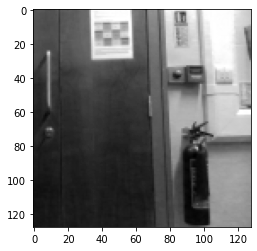

In [24]:
#Vaerify the prediction on first image
plt.imshow(train_images[0, :,:,0], cmap='gray')

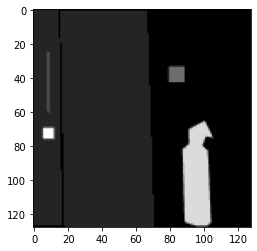

In [25]:
plt.imshow(train_masks[0], cmap='gray')

# Batch 8 - test

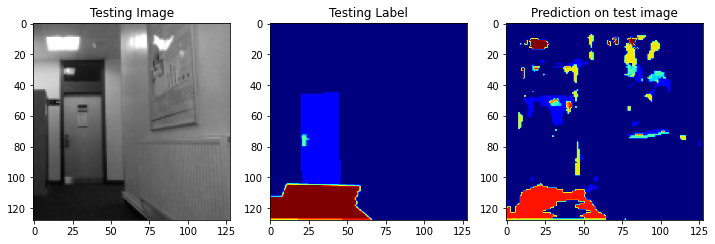

In [29]:
#Fold-1
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()

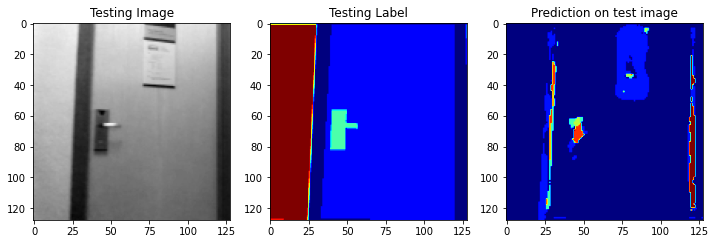

In [24]:
#Fold-2
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()

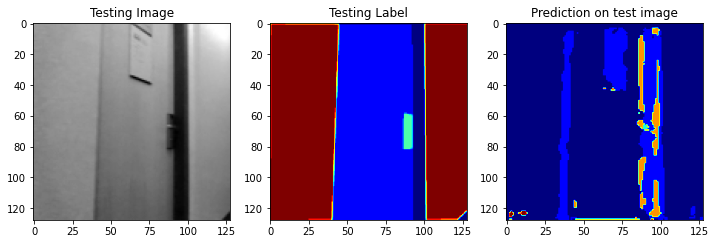

In [24]:
#Fold-3
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()

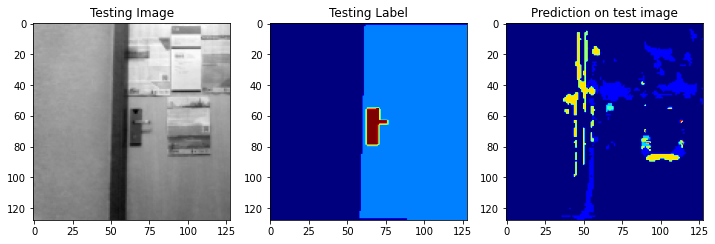

In [24]:
#Fold-4
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()

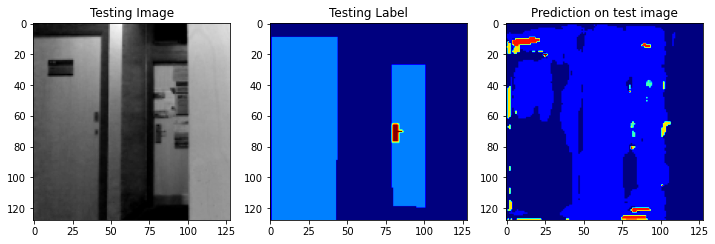

In [24]:
#Fold-5
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()

# Batch 16 - test

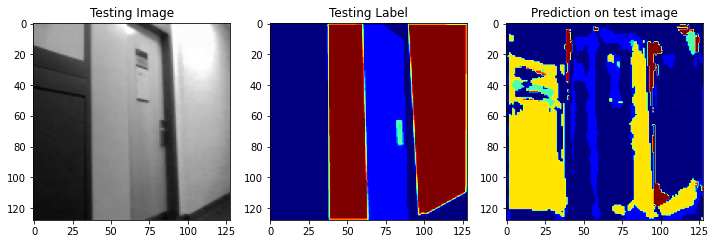

In [24]:
#Fold-1
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()

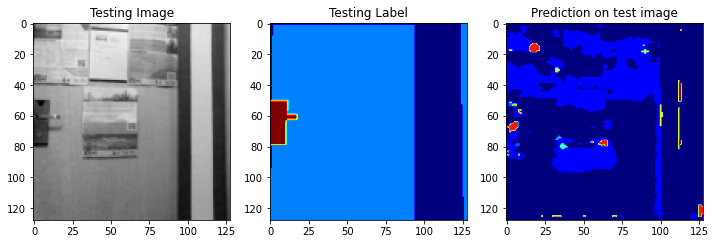

In [24]:
#Fold-2
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()

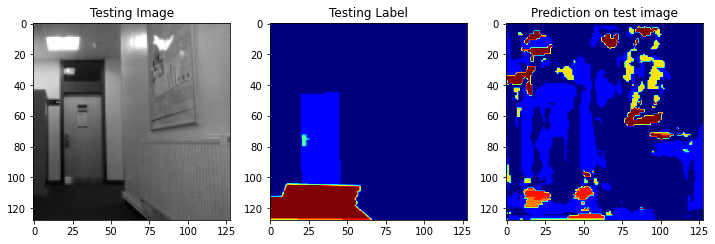

In [24]:
#Fold-3
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()

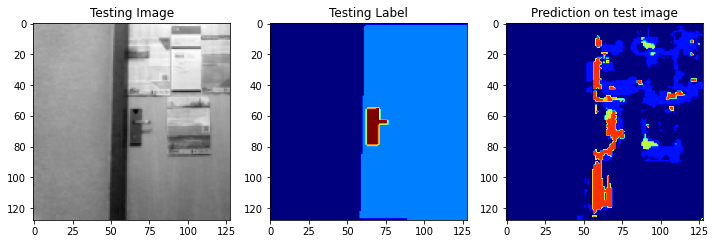

In [24]:
#Fold-4
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()

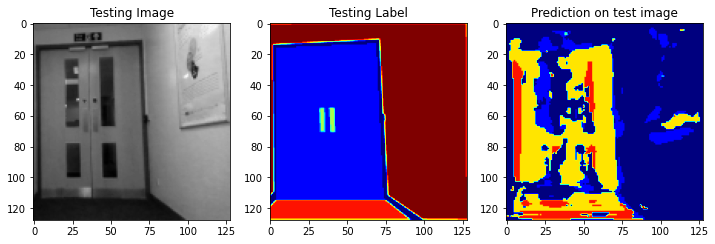

In [26]:
#Fold-5
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()

# Batch 32 - test

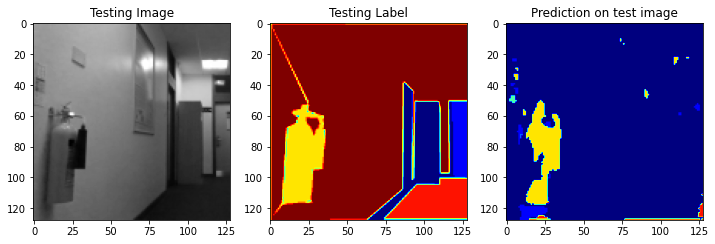

In [24]:
#Fold-1
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()

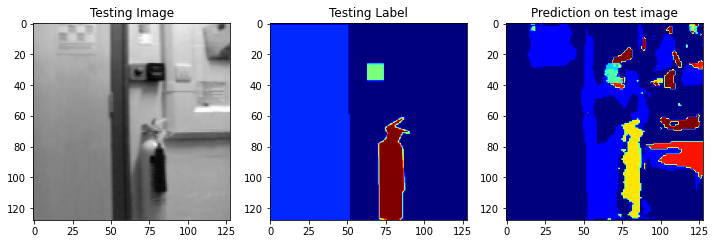

In [24]:
#Fold-2
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()

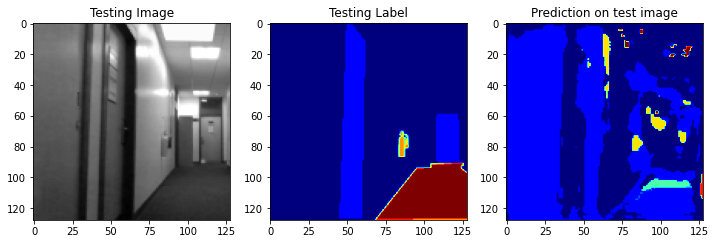

In [24]:
#Fold-3
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()

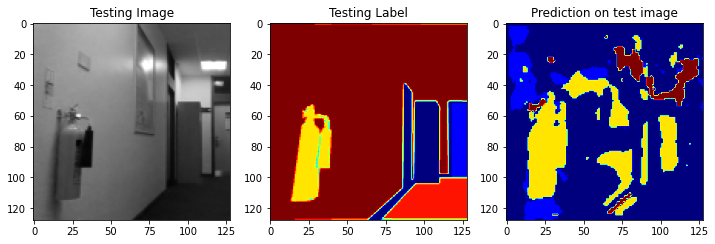

In [24]:
#Fold-4
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()

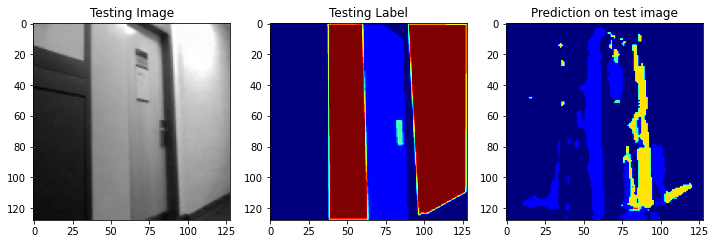

In [24]:
#Fold-5
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()